In [1]:
# !pip install Pillow>=4.2.1 matplotlib numpy>=1.11.0 jupyter pytest>=3.2.2 docopt \
#     pyyaml protobuf==3.5.2 grpcio==1.11.0 torch==0.4.0 pandas scipy ipykernel typing
# !pip install typing

In [1]:
# !pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


## 1. Imports & Setup
### 1.1 Imports

In [20]:
import torch
from torch import nn
from torch.nn.functional import mse_loss
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from typing import NamedTuple, Any
import random


In [21]:
from unityagents import UnityEnvironment

In [22]:
from dqn_agent import Agent, ReplayBuffer
from model import DQN

### 1.2 Setup

In [23]:
# please do not modify the line below
env = UnityEnvironment(file_name="/Users/bothmena/Projects/ai/ReinforcementLearning/deep-reinforcement-learning/bin/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 1.3 Training HyperParameters

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64  # mini-batch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate
UPDATE_EVERY = 4  # how often to update the network
DQN_HIDDEN_LAYERS = [64, 128, 128, 128]
model_id = '64_128_128_128'
SEED = 0


## 2 Defining Experience

In [5]:
class Experience(NamedTuple):
    state: Any
    action: Any
    reward: Any
    next_state: Any
    done: Any


## 3 Defining DQN

In [8]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_layers_units):
        super(DQN, self).__init__()
        layers = [
            nn.Linear(state_size, hidden_layers_units[0]),
        ]
        for i, units in enumerate(hidden_layers_units):
            next_units = hidden_layers_units[i+1] if i < len(hidden_layers_units) - 1 else action_size
            layers.append(nn.ReLU())
            layers.append(nn.Linear(units, next_units))

        self.fc_layers = nn.Sequential(*layers)

    def forward(self, state):
        return self.fc_layers(state)


## 4. Defining ReplayBuffer

## 5. Defining Agent

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


## 6. Setting environment up

In [10]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [11]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [12]:
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

In [13]:
env_info = env.reset(train_mode=True)[brain_name]

In [14]:
print(action_size, state_size)

4 37


In [13]:
# dir(env_info)
# dir(env)

## 7. Train the agent with DQN

In [15]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.seed = random.seed(seed)

    def add(self, experience: Experience):
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float() \
            .to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)) \
            .float().to(device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)


In [16]:
class Agent:
    def __init__(self, state_size, action_size, buffer_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.dqn_local = DQN(state_size, action_size, DQN_HIDDEN_LAYERS)
        self.dqn_target = DQN(state_size, action_size, DQN_HIDDEN_LAYERS)
        self.optimizer = Adam(self.dqn_local.parameters(), lr=LR)

        self.buffer = ReplayBuffer(action_size, buffer_size, batch_size=BATCH_SIZE, seed=seed)
        self.t_step = 0

    def step(self, experience: Experience):
        # Save experience in replay memory
        self.buffer.add(experience)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.buffer) >= BATCH_SIZE:
            experiences = self.buffer.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        random_val = np.random.random()

        if random_val < eps:
            return np.random.choice(self.action_size)

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_local.eval()
        with torch.no_grad():
            action = np.argmax(self.dqn_local(state)).item()
        self.dqn_local.train()

        return action

    def learn(self, experiences: tuple, gamma):
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        q_target_next = self.dqn_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        q_targets = rewards + (gamma * q_target_next * (1 - dones))

        # Get expected Q values from local model
        q_predicted = self.dqn_local(states)
        q_expected = q_predicted.gather(1, actions)

        # Compute loss
        loss = mse_loss(q_expected, q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update()

    def soft_update(self):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(self.dqn_target.parameters(), self.dqn_local.parameters()):
            target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)


In [17]:
agent = Agent(state_size=state_size, action_size=action_size, buffer_size=BUFFER_SIZE, seed=SEED)

In [ ]:
# first attempt: [64, 64]
scores = train_dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, save_every=2000)

Episode 100	Average Score: 0.60
Episode 200	Average Score: 3.95
Episode 300	Average Score: 6.92
Episode 400	Average Score: 10.17
Episode 500	Average Score: 11.72
Episode 600	Average Score: 14.58
Episode 700	Average Score: 15.33
Episode 800	Average Score: 14.76
Episode 803	Average Score: 14.80

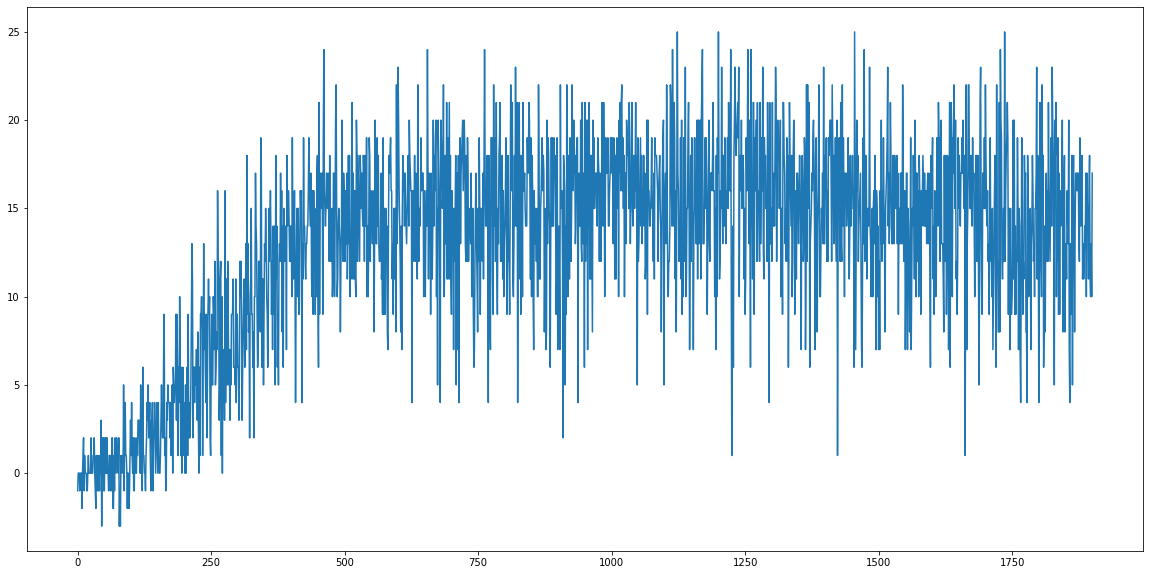

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.savefig('saved_plots/results_{}.png'.format(model_id))

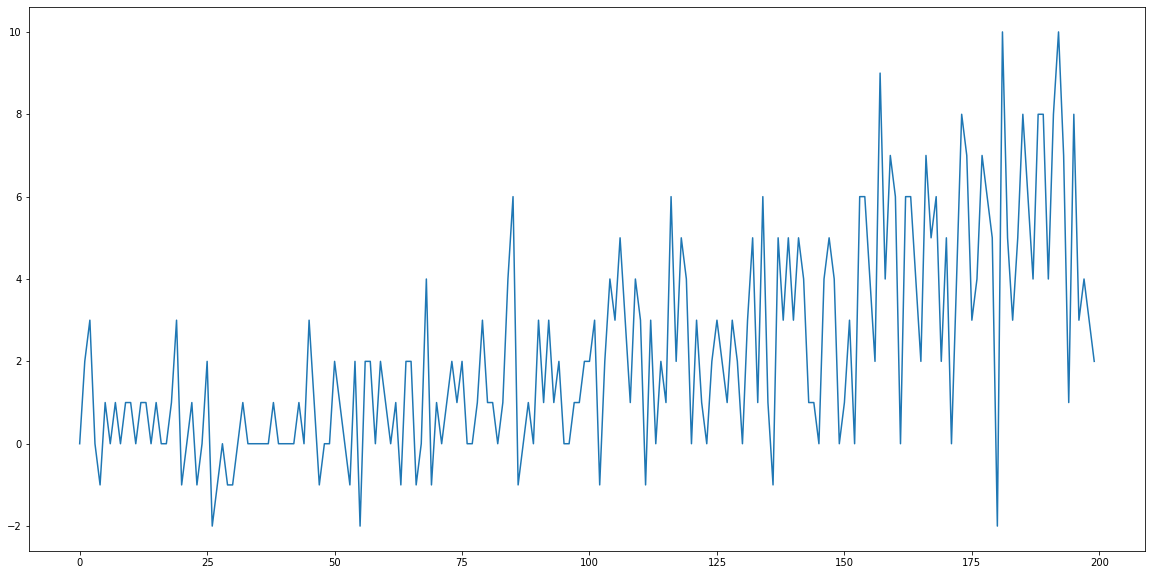

In [90]:
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.savefig('saved_plots/results_{}.png'.format(model_id))

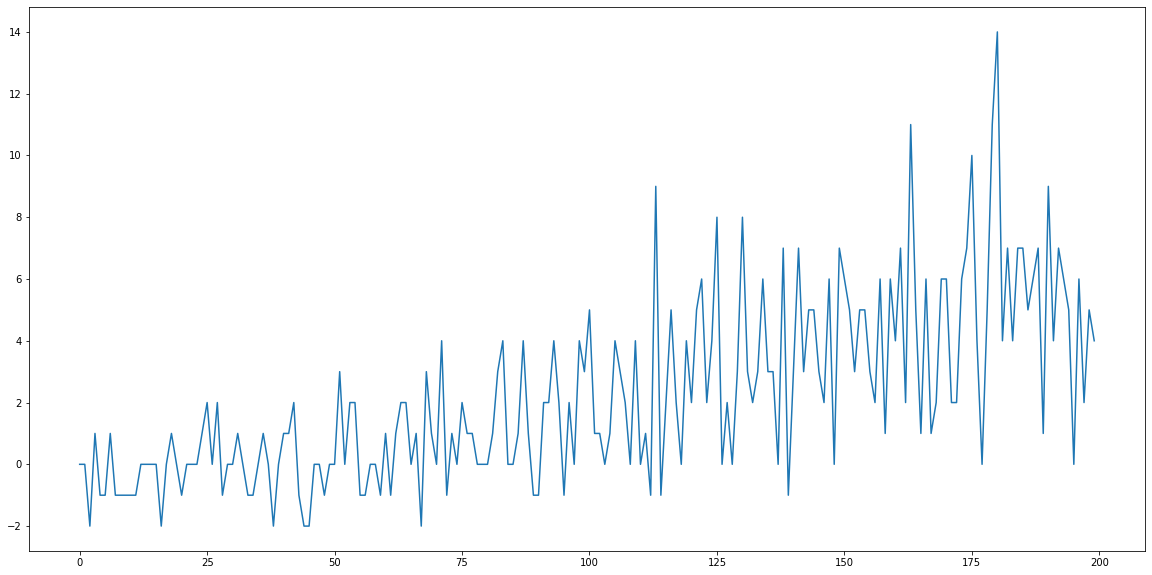

In [73]:
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.savefig('saved_plots/results_{}.png'.format(model_id))

In [108]:
scores_64_128_128_128 = get_avg_first_10()
print(scores_64_128_128_128)

[0.05, -0.5, 0.45, 1.2, 0.7, 2.0, 2.6, 2.25, 3.2]


In [74]:
scores_64_128 = get_avg_first_10()
print(scores_64_128)

[-0.35, -0.05, -0.35, 0.75, 0.45, 0.25, 0.95, 2.2, 2.55]


In [91]:
# scores_64_64_64 = get_avg_first_10()
print(scores_64_64_64)

[-0.4, 0.05, 0.1, 0.8, 1.5, 2.1, 3.3, 4.15, 4.9]


In [50]:
scores_64_64 = get_avg_first_10()
print(scores_64_64)

[0.5, -0.05, 0.3, 0.8, 1.45, 1.3, 2.65, 4.15, 5.35, 5.85]


In [49]:
step = 20
def get_avg_first_10():
    avg_scores = []
    for i in range(step, len(scores), step):
        avg = 0
        for j in range(i - step, i):
            avg += scores[j]/step
        avg_scores.append(round(avg, 2))
    
    return avg_scores[:10]


In [57]:
scores_64_128_64 = get_avg_first_10()
print(scores_64_128_64)

[-0.35, -0.05, -0.35, 0.75, 0.45, 0.25, 0.95, 2.2, 2.55]
